In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import os
import pickle

In [2]:
output_dir = '/Users/peirui/code/output_f1/'
start_time = 1
end_time = 3

In [3]:
def load_data(parms_set,output_dir):
    '''
    load pickle data and organize into dict
    parms_set: different types of parameters sets 
    Control;PD;PD_GluInh';Ctl_Glu
    '''
    data_dict_spk = {'ts_d1': [], 'ts_d2': []}
    data_dict_lfp = {
        'd1_times': [], 'd1_g_ex': [], 'd1_g_in': [], 'd1_V_m': [],
        'd2_times': [], 'd2_g_ex': [], 'd2_g_in': [], 'd2_V_m': []
    }
    # Load and process the output
    for filename in os.listdir(output_dir):
        char = filename.split('_')
        if char[1]==parms_set:
            category, subtype = char[0], char[3]
            filepath = os.path.join(output_dir, filename)

            # Load the pickle file
            with open(filepath, "rb") as file:
                evs = pickle.load(file)

            # Process 'spk' data
            if category == 'spk' and subtype in ['d1', 'd2']:
                ts = evs['events']['times']
                data_dict_spk[f'ts_{subtype}'].append(ts)

            # Process 'lfp' data
            if category == 'lfp' and subtype in ['d1', 'd2']:
                for key in ['times', 'g_ex', 'g_in', 'V_m']:
                    data_dict_lfp[f'{subtype}_{key}'].append(evs[key])
    return data_dict_spk,data_dict_lfp

In [4]:
def proecess_data_spk_firing(data_dict_spk,start_time,end_time,msn_size):
 '''
 Calculate the mean firing rate of D1 and D2 MSNs.
    
  Parameters:
  data_dict_spk (dict): Dictionary containing spike times for D1 and D2 neurons.
  start_time (float): Start time in seconds for calculating the firing rate.
  end_time (float): End time in seconds for calculating the firing rate.
  msn_size (int): Number of neurons in each population (D1 or D2).
  
  Returns:
  tuple: Two lists containing the mean firing rates for D1 and D2 neurons.
 '''
 
 # Calculate the mean firing rate of D1,D2and FSI populations
 d1_firing=[]
 d2_firing=[]

 duration_secs = float(end_time - start_time)
 start_ms = start_time * 1000
 end_ms = end_time * 1000
 for key, spike_times in data_dict_spk.items():
    
    spikes_in_window = [np.sum((spk_times > start_ms) & (spk_times < end_ms)) for spk_times in spike_times]
    firing_rate = [spk_in_window/ duration_secs / float(msn_size) for spk_in_window in spikes_in_window]

    if key.split('_')[1] == 'd1':
        d1_firing.append(firing_rate)
    elif key.split('_')[1] == 'd2':
        d2_firing.append(firing_rate)

 return d1_firing[0], d2_firing[0]



In [5]:
def process_data_spk_synchrony_index(data_dict_spk,start_time,end_time):
    
    syn_inx_d1 = []
    syn_inx_d2 = []
    start_ms = int(start_time * 1000)
    end_ms = int(end_time * 1000)

    for key, spike_times_list in data_dict_spk.items():
        # Loop through each neuron's spike times
        for spk_times in spike_times_list:
            count_list = []
            
            # Calculate spike counts in 5 ms bins
            for i in range(start_ms, end_ms, 5):
                count = np.sum((spk_times > i) & (spk_times <= i + 5))
                count_list.append(count)
            
            # Calculate the synchrony index as variance/mean of spike counts
            # refer to Yim et al. 2011 Fano factor
            mean_count = np.mean(count_list)
            var_count = np.var(count_list)
            synchrony_index = var_count / mean_count if mean_count > 0 else 0
        
            if key.split('_')[1] == 'd1':
                syn_inx_d1.append(synchrony_index)
            elif key.split('_')[1] == 'd2':
                syn_inx_d2.append(synchrony_index)

    syn_inx_d1_avg = sum(syn_inx_d1) / len(syn_inx_d1) if syn_inx_d1 else 0
    syn_inx_d2_avg = sum(syn_inx_d2) / len(syn_inx_d2) if syn_inx_d2 else 0

    syn_inx = (syn_inx_d1_avg + syn_inx_d2_avg) / 2


    return syn_inx

In [6]:
def z_score_normalize(data):    
    mean = np.mean(data, axis=0)    
    std_dev = np.std(data, axis=0)    
    normalized_data = (data - mean) / std_dev    
    return normalized_data

def compute_synaptic_current(g_ex, v_m_ex, g_in, v_m_in, E_ex1, E_in1):
    '''
    Calculate synaptic currents (I_syn = g_syn * (V_m - E_syn))
    '''
    I_syn_ex = np.sum((v_m_ex - E_ex1) * g_ex)
    I_syn_in = np.sum((v_m_in - E_in1) * g_in)
    return I_syn_ex, I_syn_in

In [7]:
def process_data_lfp(data_dict_lfp, start_time, end_time, E_ex1, E_in1):
    start_ms = int(start_time  * 1000)
    end_ms = int(end_time  * 1000)

    start_idx = int((start_ms-1)*2000)#every 2000 slices is 1 ms 
    end_idx = int((end_ms-1)*2000)

    LFP_list = []

    for gex_d1, gin_d1, vm_d1, gex_d2, gin_d2, vm_d2 in zip(data_dict_lfp['d1_g_ex'], data_dict_lfp['d1_g_in'], 
                                                             data_dict_lfp['d1_V_m'], data_dict_lfp['d2_g_ex'], 
                                                             data_dict_lfp['d2_g_in'], data_dict_lfp['d2_V_m']):
        Syn_d1_ex, Syn_d1_in, Syn_d2_ex, Syn_d2_in = [], [], [], []

        for i in range(start_idx, end_idx, 2000):
            I_syn_d1_ex, I_syn_d1_in = compute_synaptic_current(gex_d1[i-12000:i-10000], vm_d1[i-12000:i-10000], 
                                                                gin_d1[i:i+2000], vm_d1[i:i+2000], E_ex1, E_in1)
            I_syn_d2_ex, I_syn_d2_in = compute_synaptic_current(gex_d2[i-12000:i-10000], vm_d2[i-12000:i-10000], 
                                                                gin_d2[i:i+2000], vm_d2[i:i+2000], E_ex1, E_in1)
            Syn_d1_ex.append(I_syn_d1_ex)
            Syn_d1_in.append(I_syn_d1_in)
            Syn_d2_ex.append(I_syn_d2_ex)
            Syn_d2_in.append(I_syn_d2_in)

        # Calculate local field potential out of point neuron network
        # refer to Mazzoni et al. 2015  reference weighted sum LFP proxy (RWS)
        LFP_d1 = z_score_normalize(abs(np.array(Syn_d1_ex) - 1.65 * np.array(Syn_d1_in)))
        LFP_d2 = z_score_normalize(abs(np.array(Syn_d2_ex) - 1.65 * np.array(Syn_d2_in)))

        LFP_msn  = (LFP_d1+LFP_d2)/2

        LFP_list.append(LFP_msn)

    return LFP_list


In [8]:
data_dict_spk_ctl,data_dict_lfp_ctl = load_data('Control',output_dir)
data_dict_spk_pd,data_dict_lfp_pd = load_data('PD',output_dir)
data_dict_spk_pdr,data_dict_lfp_pdr = load_data('PDglu',output_dir)##name are incorrect!!! fixed
data_dict_spk_glu,data_dict_lfp_glu = load_data('CtlGlu',output_dir)

In [9]:
d1_firing_ctl,d2_firing_ctl = proecess_data_spk_firing(data_dict_spk_ctl,start_time, end_time,2000)
d1_firing_pd,d2_firing_pd = proecess_data_spk_firing(data_dict_spk_pd,start_time, end_time,2000)
d1_firing_pdr,d2_firing_pdr = proecess_data_spk_firing(data_dict_spk_pdr,start_time, end_time,2000)
d1_firing_glu,d2_firing_glu = proecess_data_spk_firing(data_dict_spk_glu,start_time, end_time,2000)

In [10]:
syn_ctl = process_data_spk_synchrony_index(data_dict_spk_ctl,start_time, end_time)
syn_pd = process_data_spk_synchrony_index(data_dict_spk_pd,start_time, end_time)
syn_pdr = process_data_spk_synchrony_index(data_dict_spk_pdr,start_time, end_time)
syn_glu = process_data_spk_synchrony_index(data_dict_spk_glu,start_time, end_time)

In [14]:
LFP_msn_ctl = process_data_lfp(data_dict_lfp_ctl, start_time, end_time, E_ex1=0, E_in1=-64)
LFP_msn_pd = process_data_lfp(data_dict_lfp_pd, start_time, end_time, E_ex1=0, E_in1=-64)
LFP_msn_pdr = process_data_lfp(data_dict_lfp_pdr, start_time, end_time, E_ex1=0, E_in1=-64)
LFP_msn_glu = process_data_lfp(data_dict_lfp_glu, start_time, end_time, E_ex1=0, E_in1=-64)

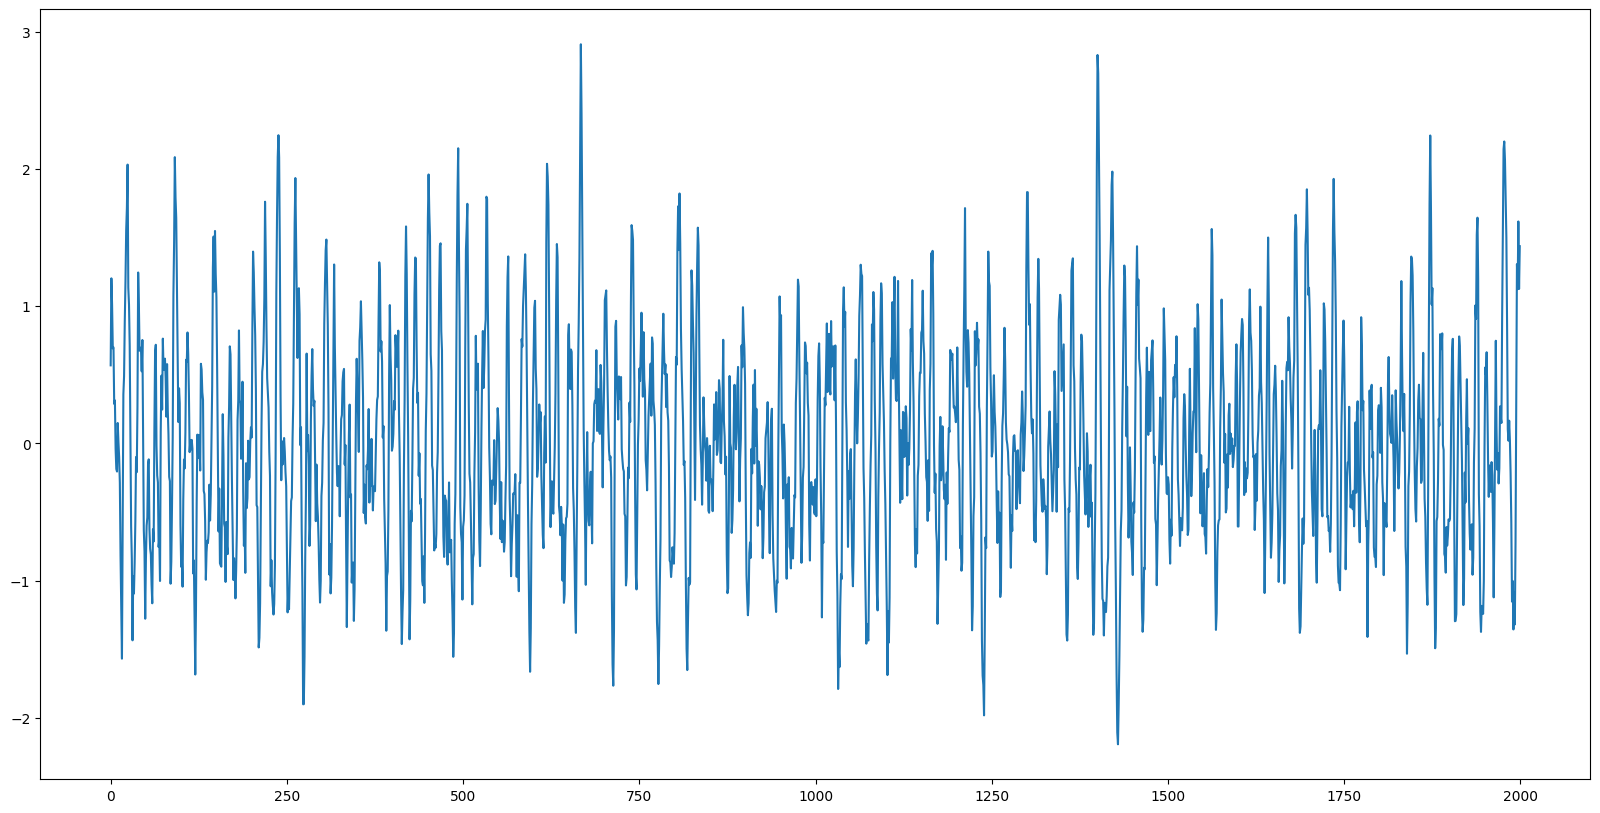

In [15]:
plt.figure(figsize=(20,10))
plt.plot(LFP_msn_ctl[2])


In [16]:
from scipy.fft import fft, fftfreq
import scipy.signal as signal
def compute_psd_fft(data,fs,start_freq,end_freq):
    N = 2000
    T = 1/fs
    fft_y = fft(data)
    power_spectrum = (np.abs(fft_y) ** 2)[:N//2]
    xf = fftfreq(N, T)[:N//2]
    psd_norm = power_spectrum / (N * fs)#normalize
    psd_db = 10 * np.log10(psd_norm)

    return psd_norm[start_freq*2:end_freq*2+1],xf[start_freq*2:end_freq*2+1]

def compute_psd_welch(data,fs,start_freq,end_freq):
    frequencies, psd = signal.welch(data, fs=fs, nperseg=2000)
    return psd[start_freq*2:end_freq*2+1],frequencies[start_freq*2:end_freq*2+1]


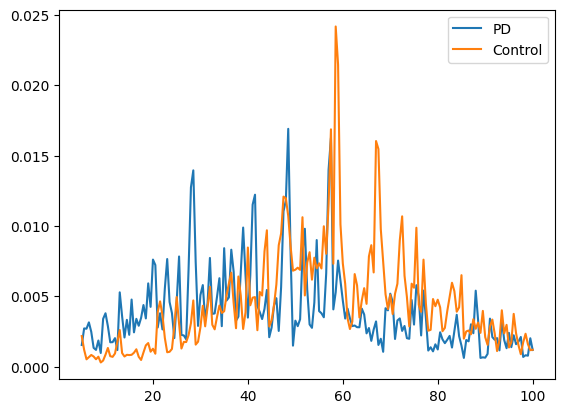

In [20]:

psd_pd=[]
psd_ctl=[]
for i in range(len(LFP_msn_pd)):
    power_spectrum,xf = compute_psd_welch(LFP_msn_pd[i],1000,start_freq=5,end_freq=100)
    power_spectrum_ctl,xf = compute_psd_welch(LFP_msn_ctl[i],1000,start_freq=5,end_freq=100)
    psd_pd.append(power_spectrum)
    psd_ctl.append(power_spectrum_ctl)

plt.plot(xf,np.mean(np.array(psd_pd),axis=0),label='PD')
plt.plot(xf,np.mean(np.array(psd_ctl),axis=0),label='Control')
plt.legend()
plt.show()


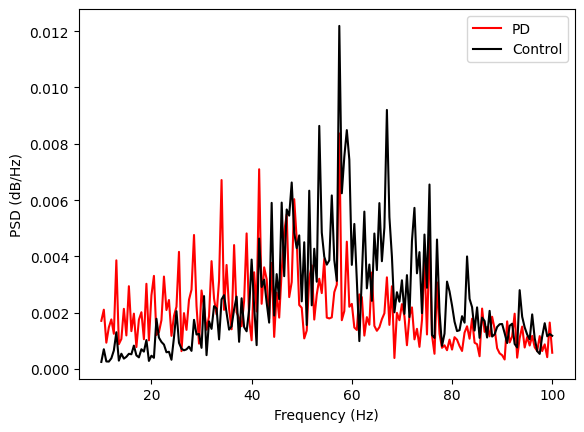

In [20]:

psd_pd=[]
psd_ctl=[]
psd_pdr=[]
psd_glu=[]
for i in range(len(LFP_msn_pd)):
    power_spectrum,xf = compute_psd_fft(LFP_msn_pd[i],1000,start_freq=10,end_freq=100)
    power_spectrum_ctl,xf = compute_psd_fft(LFP_msn_ctl[i],1000,start_freq=10,end_freq=100)
    power_spectrum_pdr,xf = compute_psd_fft(LFP_msn_pdr[i],1000,start_freq=10,end_freq=100)
    power_spectrum_glu,xf = compute_psd_fft(LFP_msn_glu[i],1000,start_freq=10,end_freq=100)
    psd_pd.append(power_spectrum)
    psd_ctl.append(power_spectrum_ctl)
    psd_pdr.append(power_spectrum_pdr)
    psd_glu.append(power_spectrum_glu)

plt.plot(xf,np.mean(np.array(psd_pd),axis=0),label='PD',color='red')
plt.plot(xf,np.mean(np.array(psd_ctl),axis=0),label='Control',color='k')
#plt.plot(xf,np.mean(np.array(psd_pdr),axis=0),label='No DA+Glu Inh',color='blue')
#plt.plot(xf,np.mean(np.array(psd_glu),axis=0),label='Control+Glu Exc',color='green')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.legend()
plt.show()


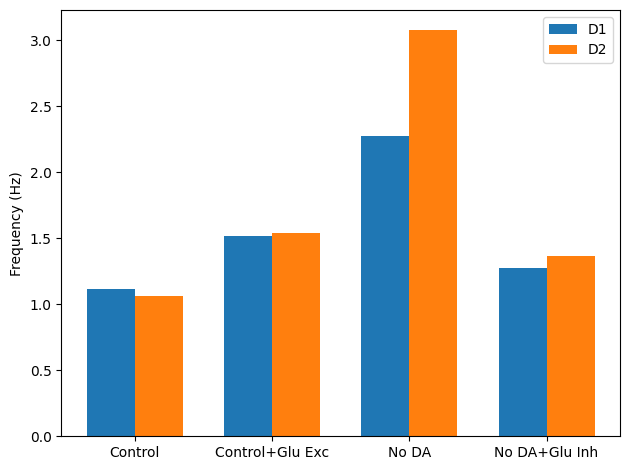

In [16]:

# Assuming d1_firing_* and d2_firing_* are lists of firing rates
# Calculate means
mean_d1_ctl = np.mean(d1_firing_ctl)
mean_d2_ctl = np.mean(d2_firing_ctl)

mean_d1_glu = np.mean(d1_firing_glu)
mean_d2_glu = np.mean(d2_firing_glu)

mean_d1_pd = np.mean(d1_firing_pd)
mean_d2_pd = np.mean(d2_firing_pd)

mean_d1_pdr = np.mean(d1_firing_pdr)
mean_d2_pdr = np.mean(d2_firing_pdr)

# Data for bar chart
labels = ['Control', 'Control+Glu Exc', 'No DA', 'No DA+Glu Inh']
d1_means = [mean_d1_ctl, mean_d1_glu, mean_d1_pd, mean_d1_pdr]
d2_means = [mean_d2_ctl, mean_d2_glu, mean_d2_pd, mean_d2_pdr]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, d1_means, width, label='D1')
rects2 = ax.bar(x + width/2, d2_means, width, label='D2')

ax.set_ylabel('Frequency (Hz)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


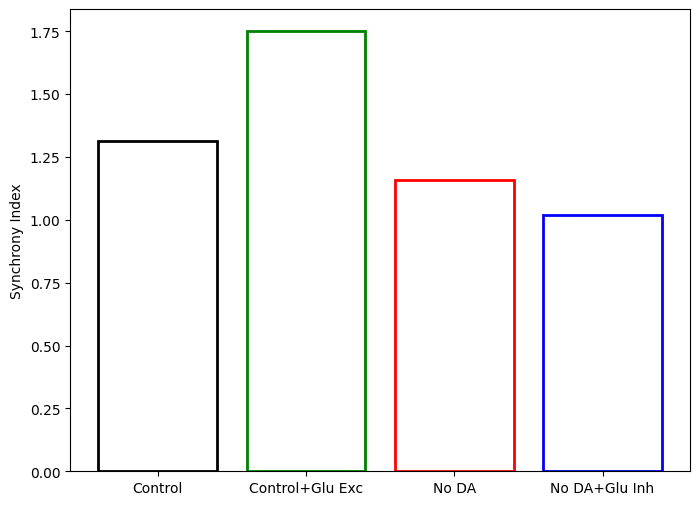

In [17]:

syn_values = [syn_ctl, syn_glu, syn_pd, syn_pdr ]
labels = ['Control', 'Control+Glu Exc', 'No DA', 'No DA+Glu Inh']

# Bar colors (white bars with different border colors)
bar_colors = ['white', 'white', 'white', 'white']
edge_colors = ['black', 'green','red','blue' ]

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, syn_values, color=bar_colors, edgecolor=edge_colors, linewidth=2)
plt.ylabel('Synchrony Index')
plt.show()
